In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def average_rate(active_cases, convergence_number, initial_average_rate, final_average_rate):
    ''' 
    Returns the average rate of spread from the number of active cases. 
    
    When the active cases are small and rising, the average_rate decreases quadratically. It eventually 
    converges to final_average_rate and after then stops changing.
    '''
    if active_cases>convergence_number:
        return final_average_rate
    return final_average_rate + (initial_average_rate-final_average_rate)\
            *(convergence_number-active_cases)**2/convergence_number**2

In [3]:
def non_infected_fraction(active_cases, convergence_number, initial_average_rate, final_average_rate, initial_population):
    '''         
    Assume each infected person can "potentially infect" average_rate number of people per day. I say "potentially infect"
    because some of these are already infected. Calculate the probabily of not getting infected which is the same as
    non_infected_fraction.
    '''
    return (1-average_rate(active_cases, convergence_number, initial_average_rate, 
                          final_average_rate)/initial_population)**active_cases

In [4]:
def run(initial_average_rate = 3/14, final_average_rate = 1.4/14, active_cases = 3, recovery_rate = 0.97, 
        initial_population = 3000000, healthcare_capacity_fraction = 5/1000, max_days = 1000,
        medical_attention_needed_fraction = 0.14,  immunity_development = 0.8, convergence_number = 10000):
    '''
    Runs the simulation.

    Input:

    initial_average_rate (float): average rate of spread per day initially. COVID19's R0 is around 3. 
    Assume one infection lasts 14 days (2 weeks). 

    final_average_rate (float): the final average rate that the model converges to.

    active_cases (float): the number of active cases on a day. Initialized to 3.

    recovery_rate (float): recovery rate when hospitals have space for every patient.

    initial_population (int): initial population of the country.

    healthcare_capacity_fraction (float): initialized to 5 bed for 1,000 patients.

    max_days (int): number of days (iterations) for the simulation to run.

    medical_attention_needed_fraction (float): fraction of infected people who need serious medical care.

    immunity_development (float): fraction of infected people who develop perfect immunity (cannot be reinfected). 
    Assume the remaining do not develop immunity at all (can be reinfected with the same probability as 
    previously non-infected people). Initialized to 0.8.

    convergence_number (int): a parameter of the model. Specifies the number of active cases needed
    for the average rate to converge to final_average_rate.

    Output: 

    active_cases_list (list): a list of active cases for each day.
    daily_new_cases (list): a list of daily new cases for each day.
    daily_dead_people (list): a list of daily deaths for each day.

    '''
    healthcare_capacity = healthcare_capacity_fraction*initial_population/14 # for each day
    # the population of people who can be infected. moving_population = initial_population - deaths - immune people
    moving_population = initial_population 
    
    # output lists.
    active_cases_list = []
    daily_new_cases = []   
    daily_dead_people = []
    
    for t in range(0, max_days):
        not_infected_fraction = non_infected_fraction(active_cases, convergence_number, 
                                                      initial_average_rate, final_average_rate, initial_population)
        new_daily_cases = (1 - not_infected_fraction) * (moving_population - active_cases)
        
        daily_new_cases.append(new_daily_cases)
        active_cases_list.append(active_cases)
        active_cases += new_daily_cases
        
        # Assume at day t, all people at t-14 either die or recover
        changed_state = 0 if t <= 14 else daily_new_cases[t - 14] 
        active_cases -= changed_state
        recovered_today = changed_state * recovery_rate
        if changed_state * medical_attention_needed_fraction > healthcare_capacity:
            recovered_today = (1-medical_attention_needed_fraction)*changed_state + healthcare_capacity
        daily_dead_people.append(changed_state - recovered_today)
        moving_population = moving_population - (changed_state - recovered_today) - immunity_development * recovered_today
    return active_cases_list, daily_new_cases, daily_dead_people

In [5]:
# find the difference of deaths when an individual self-isolates for final_average_rate = 1.2
total_death_diff = np.sum(np.array(run(final_average_rate = 1.2/14)[2])) - \
np.sum(np.array(run(final_average_rate = 1.2/14 - 2/(14*3000000))[2]))
print(total_death_diff)

0.08178232525824569


In [6]:
dictionary = {}
for frate in range(4, 20):
    dictionary[frate] = run(final_average_rate = frate/(10*14))

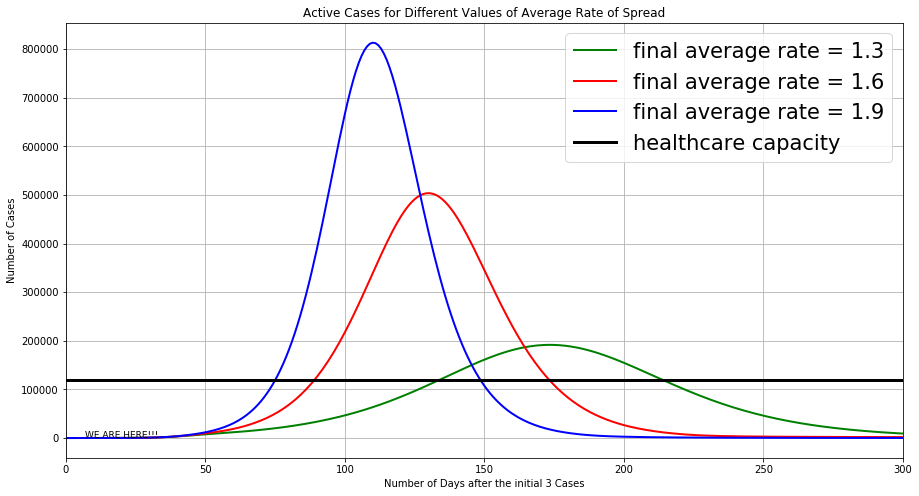

In [7]:
# Plot Active Cases

plt.figure(figsize=(15,8))
plt.grid()
plt.title('Active Cases for Different Values of Average Rate of Spread')
plt.xlabel('Number of Days after the initial 3 Cases')
plt.ylabel('Number of Cases')

plt.plot(dictionary[13][0], 'g', linewidth = 2, label = 'final average rate = 1.3')
plt.plot(dictionary[16][0], 'r', linewidth = 2, label = 'final average rate = 1.6')
plt.plot(dictionary[19][0], 'b', linewidth = 2, label = 'final average rate = 1.9')

# For illustration purposes only. Not the actual value.
plt.plot(120000+np.zeros(1000), 'black', linewidth = 3, label = 'healthcare capacity')

# Show where we are on the curve as of 19 March.
plt.text(7, 150, 'WE ARE HERE!!!', fontsize = 9)

plt.legend(loc='upper right', fontsize = 21)

plt.xlim([0, 300])
# plt.ylim(0, 20000)
plt.show()

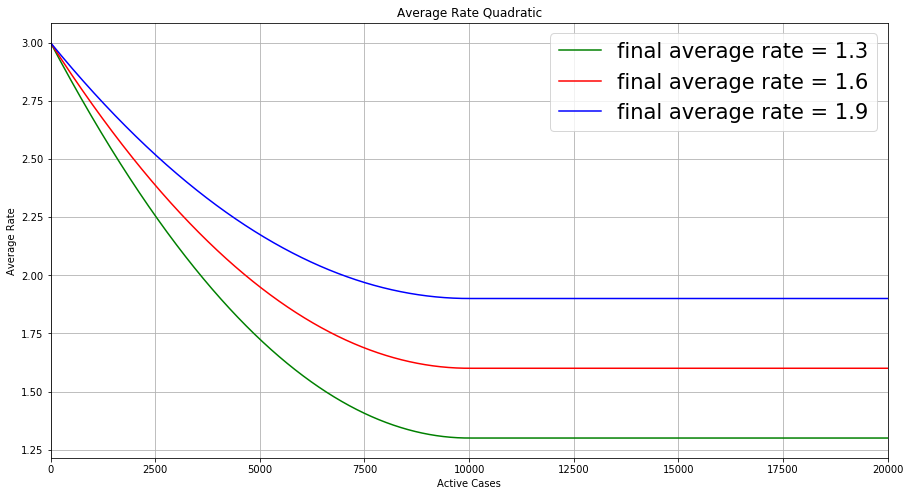

In [8]:
# Plot quadratics
convergence_number = 10000
initial_average_rate = 3/14

plt.figure(figsize=(15,8))
x = np.linspace(0, 30000, 90000) 
plt.grid()
vfunc = np.vectorize(average_rate)
y3 = vfunc(x, convergence_number, initial_average_rate, 1.3/14)
plt.plot(x, 14*y3, 'g', label = 'final average rate = 1.3')
y2 = vfunc(x, convergence_number, initial_average_rate, 1.6/14)
plt.plot(x, 14*y2, 'r', label = 'final average rate = 1.6')
y1 = vfunc(x, convergence_number, initial_average_rate, 1.9/14)
plt.plot(x, 14*y1, 'b', label = 'final average rate = 1.9')

plt.legend(loc='upper right', fontsize = 21)

plt.xlabel('Active Cases')
plt.ylabel('Average Rate')
plt.title('Average Rate Quadratic')

plt.xlim(0, 20000)
plt.show()

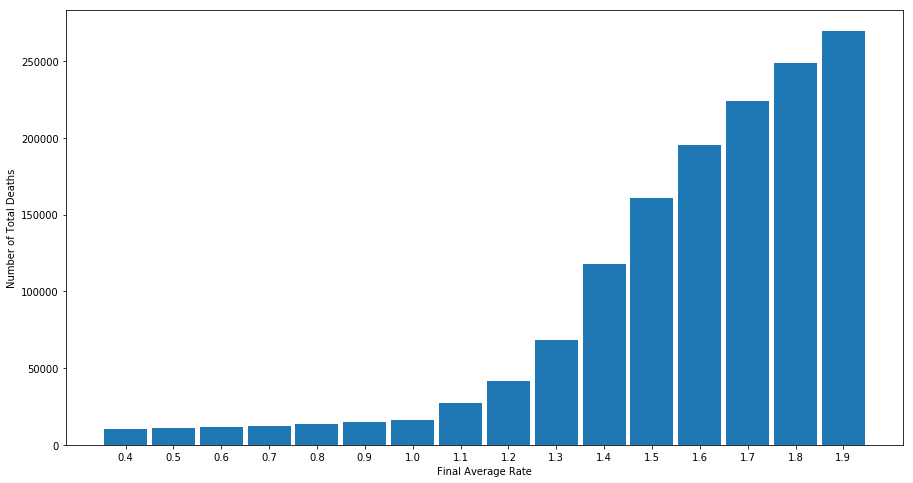

In [9]:
# Plot number of deaths against final average rate

final_average_rates = np.array(list(dictionary.keys()))
deaths = [np.sum(np.array(dictionary[i][2])) for i in final_average_rates]

plt.figure(figsize=(15,8))
plt.xticks(final_average_rates/10)
plt.xlabel('Final Average Rate')
plt.ylabel('Number of Total Deaths')

plt.bar(final_average_rates/10, deaths, width = 0.09)
plt.show()

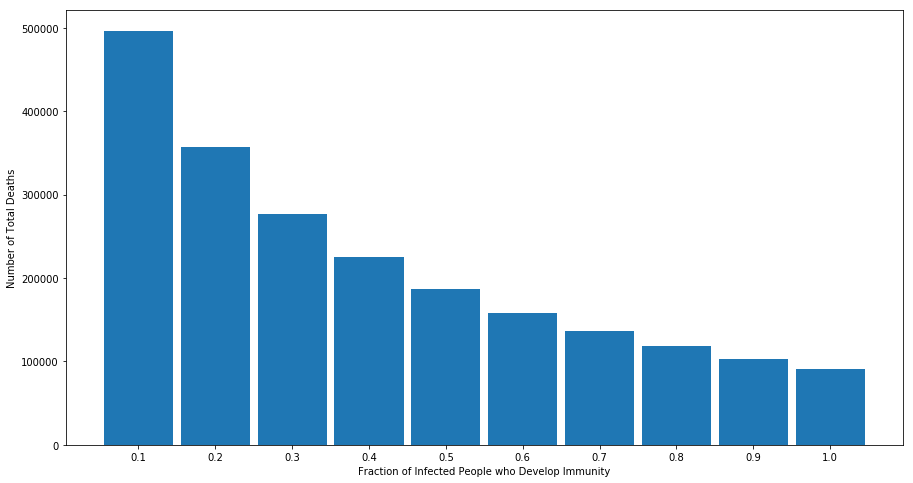

In [10]:
# Plot Number of Deaths against Immunity Development

immunity_fractions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
deaths = [np.sum(np.array(run(immunity_development = i)[2])) for i in immunity_fractions]

plt.figure(figsize=(15,8))
plt.xticks(immunity_fractions)
plt.xlabel('Fraction of Infected People who Develop Immunity')
plt.ylabel('Number of Total Deaths')

plt.bar(immunity_fractions, deaths, width = 0.09)
plt.show()

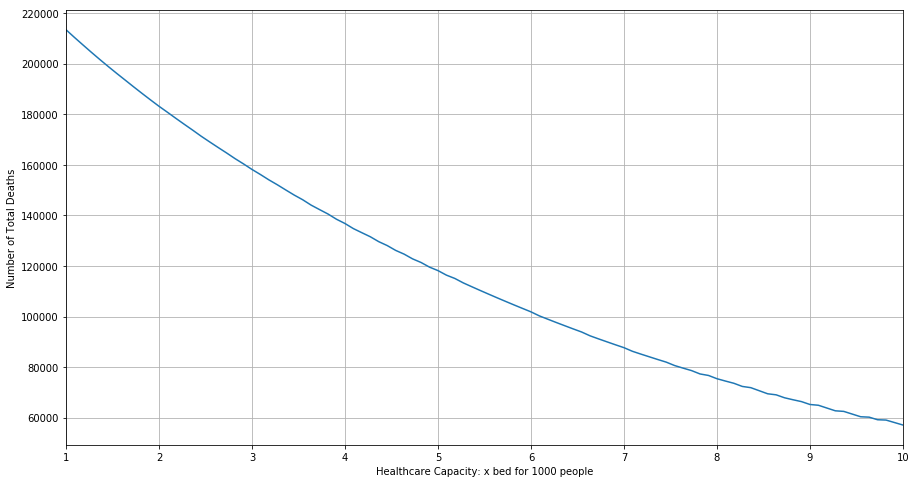

In [11]:
# Plot Number of Deaths Against Healthcare Capacity

healthcare_capacity = np.linspace(1, 10, 100)
deaths = [np.sum(np.array(run(healthcare_capacity_fraction = i/1000)[2])) for i in healthcare_capacity]

plt.figure(figsize=(15,8))
plt.xlabel('Healthcare Capacity: x bed for 1000 people')
plt.ylabel('Number of Total Deaths')
plt.grid()
plt.xlim(1, 10)
plt.plot(healthcare_capacity, deaths)
plt.show()